In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

# https://pytorch.org/vision/0.11/auto_examples/plot_repurposing_annotations.html

# tracker = Tracker(metric, max_age=50, n_init=3)


Adjust the max_age:

If you want to increase the buffer time (i.e., how long a tracked object remains after losing it), increase the max_age.
If you want to decrease the buffer time (i.e., to quickly remove lost objects from tracking), decrease the max_age.

Other Parameters Affecting Object Tracking:
n_init: This parameter specifies the number of consecutive detections needed to consider an object as a valid track. Increasing n_init requires more confirmed detections for an object to start being tracked, and decreasing it will allow the tracker to start tracking objects more quickly.

min_hits (in some implementations): This defines the minimum number of consecutive frames where an object needs to be detected to be considered a valid track.

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


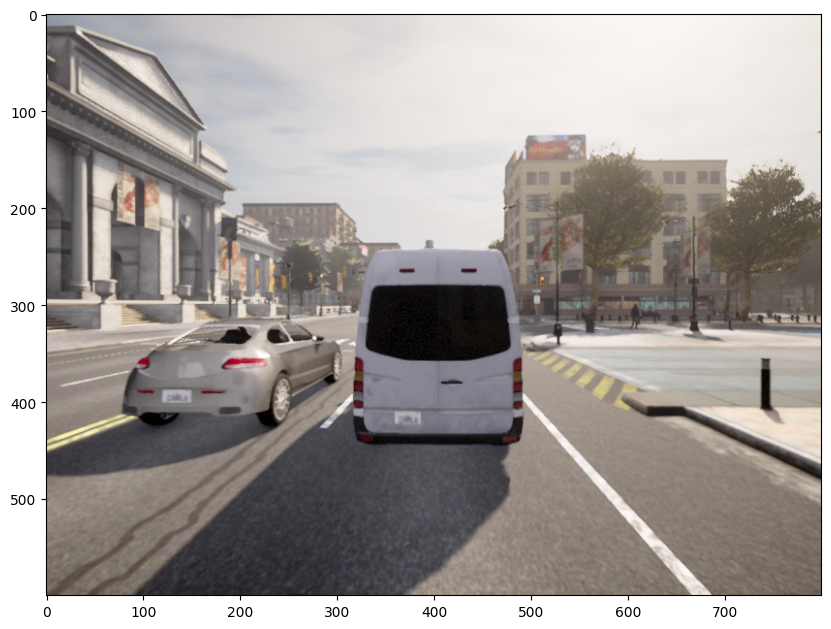

In [3]:
image = cv2.imread('/home/irfan/research/Thesis/HD_Map/HD_Map/rgb/00003854.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [4]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/home/irfan/research/Thesis/segment_anything/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

/home/irfan/miniconda3/envs/net/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
predictor.set_image(image)

polarities:  [False False False ... False False False]


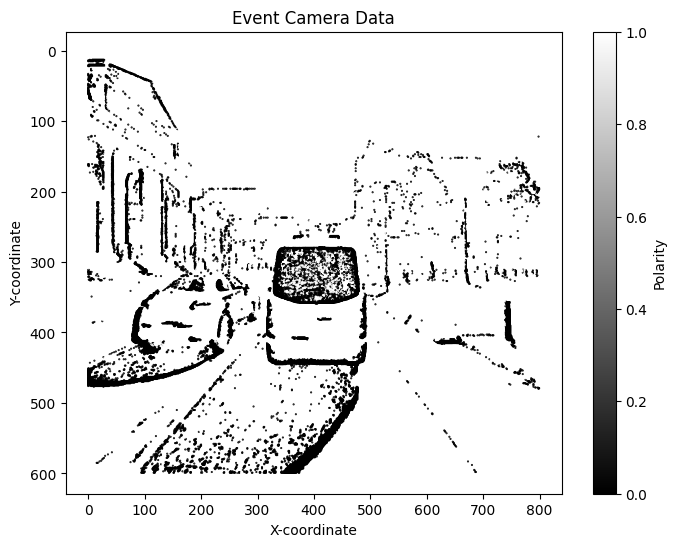

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Load the .npy file
data = np.load('/home/irfan/research/Thesis/HD_Map/HD_Map/dvs/00003854.npy', allow_pickle=True)

# Extract event data
timestamps = data.item()["t"]
x_coords = data.item()["x"]
y_coords = data.item()["y"]
polarities = data.item()["pol"]
print("polarities: ", polarities)
# Plot events
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, c=polarities, cmap='gray', marker='.', s=1)
plt.title('Event Camera Data')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.gca().invert_yaxis()  # Invert y-axis to match typical image coordinates
plt.colorbar(label='Polarity')
plt.show()

Remove the common points

In [8]:
import numpy as np

def combine_arrays(x, y, polarity):
    # Ensure x, y, and polarity are numpy arrays
    x = np.array(x)
    y = np.array(y)
    polarity = np.array(polarity)
    
    # Combine x and y into a 2D array
    combined = np.vstack((x, y)).T
    
    # Filter the combined array where polarity is True and coordinates are not the same
    filtered_combined = combined[polarity]
    
    # Find unique rows and their counts
    unique_rows, counts = np.unique(filtered_combined, axis=0, return_counts=True)
    
    # Select rows that appear only once
    result = unique_rows[counts == 1]
    
    return result

# Example usage




result = combine_arrays(x_coords, y_coords, polarities)
print(len(result))

8786


Unsuccesful Technique select only the far away points

In [9]:
import random
import math

def distance(p1, p2):
    """Calculate the Euclidean distance between two points p1 and p2."""
    return math.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

def select_far_points(points, num_points=500, min_distance=10):
    """
    Select a specified number of points from the input list such that each selected point
    is at least min_distance away from all other selected points.
    
    Parameters:
    points (list of tuples): The list of points to sample from.
    num_points (int): The number of points to select. Default is 500.
    min_distance (float): The minimum distance between any two selected points.
    
    Returns:
    list of tuples: A list of selected points.
    """
    # Ensure there are enough points to sample
    if len(points) < num_points:
        raise ValueError("The input list does not contain enough points to sample the specified number.")
    
    selected_points = []
    while len(selected_points) < num_points:
        candidate = random.choice(points)
        # Check if candidate is far enough from all selected points
        if all(distance(candidate, sp) >= min_distance for sp in selected_points):
            selected_points.append(candidate)
    
    return selected_points

# Example usage
selected_points = select_far_points(result, num_points=500, min_distance=40)

# Convert the selected points to a simple 2D array
selected_points_array = [[point[0], point[1]] for point in selected_points]

print(len(selected_points_array))
print(selected_points_array[:10])  # Print first 10 selected points for verification



/tmp/ipykernel_30625/1963716814.py:6: RuntimeWarning: overflow encountered in scalar subtract
  return math.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)


500
[[28, 260], [297, 364], [270, 326], [161, 411], [142, 85], [28, 63], [365, 398], [101, 376], [29, 135], [28, 249]]


In [10]:
len(selected_points_array)

500

In [11]:
input_point = np.array([[500, 375]])
input_label = np.array([1])
array = np.ones(500)
input_label=array
input_point=np.array(selected_points_array)


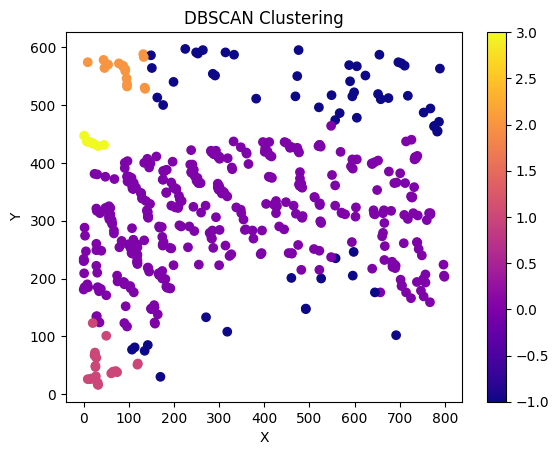

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Generate sample data
np.random.seed(0)
points = input_point

# # Compute the k-nearest neighbors distances
# k = 4  # Typically, min_samples=4 is a good choice
# neighbors = NearestNeighbors(n_neighbors=k)
# # neighbors_fit = neighbors.fit(points)
# distances, indices = neighbors_fit.kneighbors(points)

# # Sort distances and plot
# distances = np.sort(distances[:, k-1], axis=0)
# plt.plot(distances)
# plt.xlabel('Points')
# plt.ylabel(f'{k}th Nearest Neighbor Distance')
# plt.title('k-distance Graph')
# plt.show()

# Choose eps based on the k-distance graph (elbow method)
eps = 50  # Adjust this value based on the graph

# DBSCAN clustering
dbscan = DBSCAN(eps=eps, min_samples=10)
clusters = dbscan.fit_predict(points)

# Plotting the results
plt.scatter(points[:, 0], points[:, 1], c=clusters, cmap='plasma')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('DBSCAN Clustering')
plt.colorbar()
plt.show()


Clusstering of the point to find select only the dense point

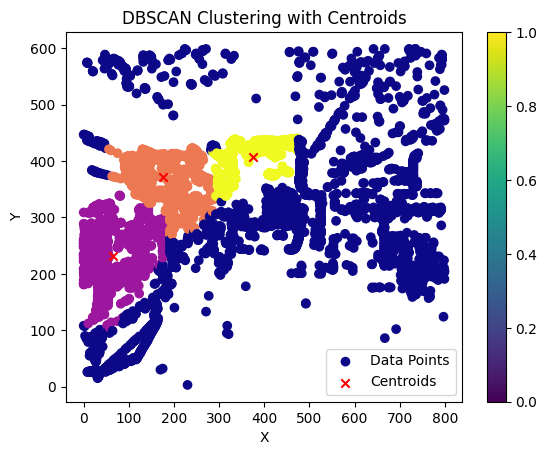

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Generate sample data
# points = input_point
points=result

# Choose eps based on the k-distance graph (elbow method)
eps = 40 # Adjust this value based on the graph

# DBSCAN clustering
dbscan = DBSCAN(eps=eps, min_samples=300)
clusters = dbscan.fit_predict(points)

# Calculate centroids
unique_clusters = set(clusters)
centroids = []
for cluster in unique_clusters:
    if cluster != -1:  # Ignore noise points
        cluster_points = points[clusters == cluster]
        centroid = cluster_points.mean(axis=0)
        centroids.append(centroid)

centroids = np.array(centroids)

# Plotting the results
plt.scatter(points[:, 0], points[:, 1], c=clusters, cmap='plasma', label='Data Points')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', label='Centroids')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('DBSCAN Clustering with Centroids')
plt.legend()
plt.colorbar()
plt.show()


In [15]:
input_point=centroids
array=np.ones(centroids.shape[0])
print(array)

[1. 1. 1.]


In [16]:
print(centroids)

[[ 64.50321802 231.76870475]
 [175.29464286 371.96875   ]
 [375.2889115  407.7792472 ]]


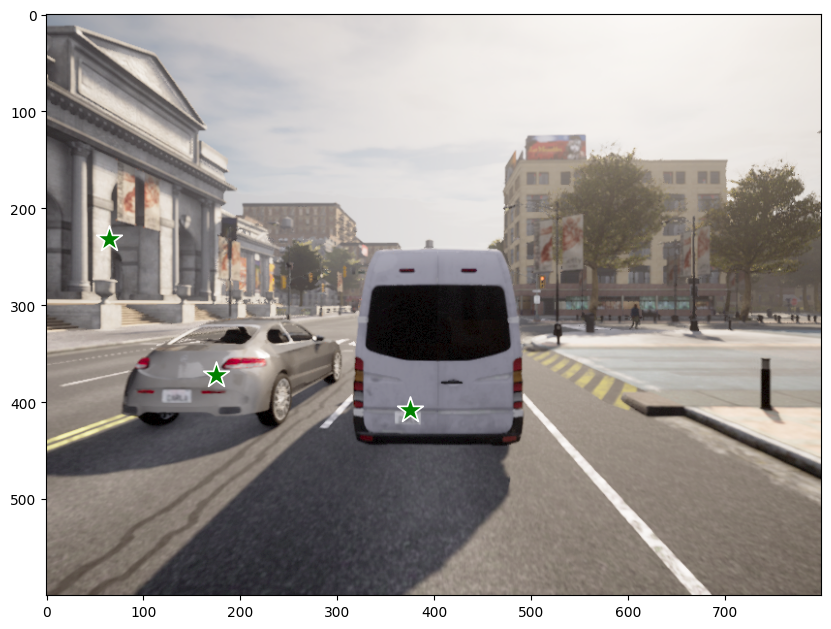

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(centroids,array, plt.gca())
plt.axis('on')
plt.show()  

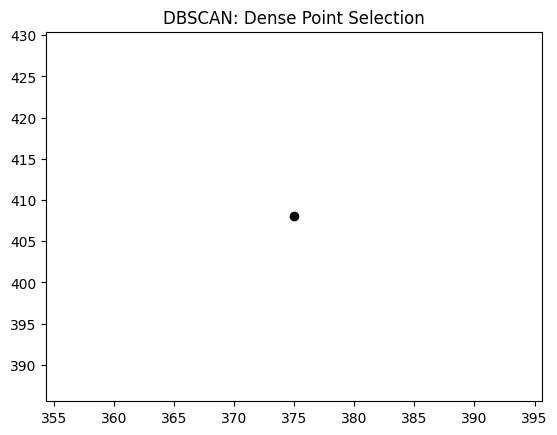

Dense points (inliers):
[]


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Generate synthetic data
np.random.seed(0)
n_samples = 500
X = input_point

# Apply DBSCAN
db = DBSCAN(eps=0.5, min_samples=10).fit(X)
labels = db.labels_

# Identify core samples, inliers (dense points) and outliers
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
outliers_mask = labels == -1

# Plot results
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]  # Black for outliers
    class_member_mask = labels == k
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)
plt.title('DBSCAN: Dense Point Selection')
plt.show()

# Extract dense points
dense_points = X[~outliers_mask]

# Print dense points
print("Dense points (inliers):")
print(dense_points)


In [28]:
input_point=np.array([[375 , 408 ]])
input_point=np.round(centroids).astype(int)
array=np.ones(centroids.shape[0])
# array=[1]

In [29]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=array,
    multimask_output=True,
)

In [20]:
input_point=[centroids]
array=np.ones(centroids.shape[0])
# array=[1]

In [30]:

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [31]:
masks, scores, logits = predictor.predict(
    # point_coords=input_point,
    point_coords=input_point,
    point_labels=array,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

/home/irfan/miniconda3/envs/net/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


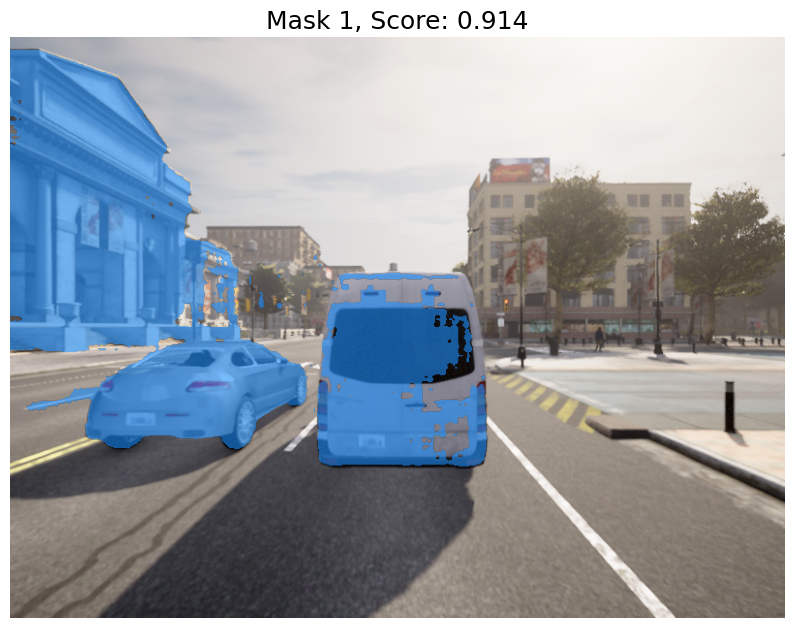

In [32]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    # show_points(input_point, array, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [ ]:
centroids

In [33]:
input_point=np.array([[375 , 408 ]])
# input_point=np.round(centroids).astype(int)
array=[1]
masks, scores, logits = predictor.predict(
    # point_coords=input_point,
    point_coords=input_point,
    point_labels=array,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

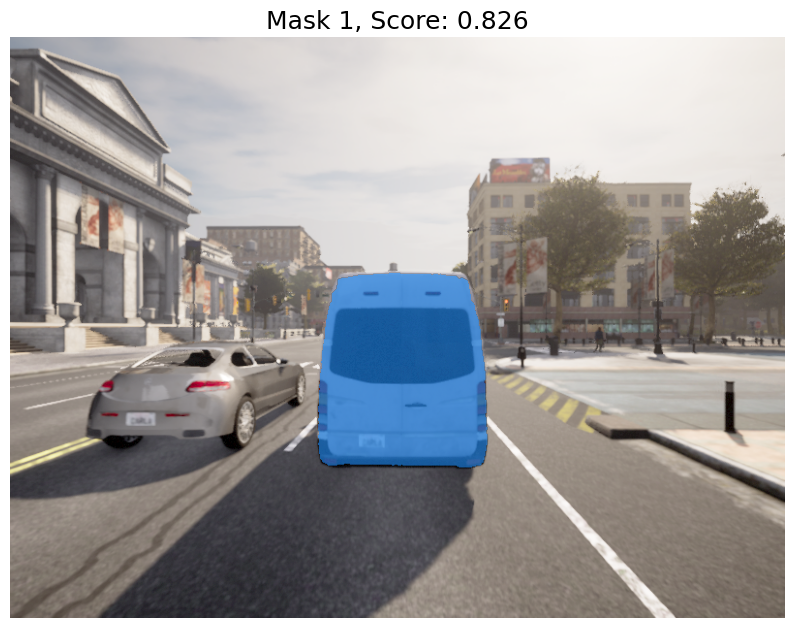

In [34]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    # show_points(input_point, array, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [35]:
input_point=np.array([[175, 378  ]])
# input_point=np.round(centroids).astype(int)
array=[1]
masks2, scores2, logits = predictor.predict(
    # point_coords=input_point,
    point_coords=input_point,
    point_labels=array,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

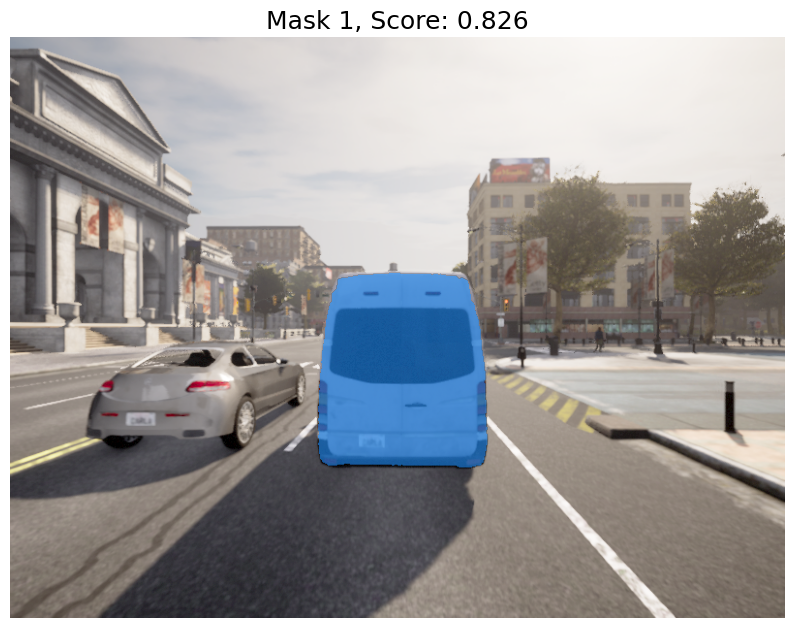

In [36]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    # show_points(input_point, array, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

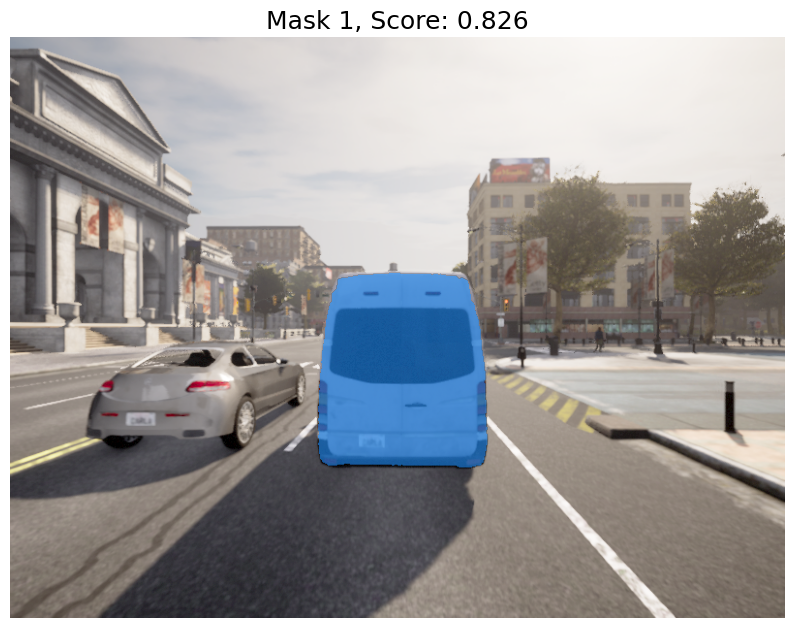

In [37]:
input_point=np.array([[65, 232  ]])
# input_point=np.round(centroids).astype(int)
array=[1]
masks3, scores3, logits = predictor.predict(
    # point_coords=input_point,
    point_coords=input_point,
    point_labels=array,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    # show_points(input_point, array, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [38]:

print(boxes.size())
print(boxes)





NameError: name 'boxes' is not defined

In [39]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


ASSETS_DIRECTORY = "assets"

plt.rcParams["savefig.bbox"] = "tight"


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [40]:
boxes=np.array([[318., 244., 492., 444.],[300., 200., 492., 444.]])
torch_boxes = torch.tensor(boxes).float()

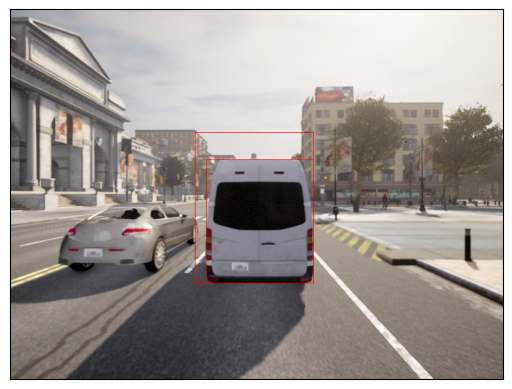

In [41]:
# image_torh = torch.from_numpy(image)
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import masks_to_boxes
int_array = np.where(masks, 255, 0)
torch_tensor = torch.from_numpy(int_array)
# boxes = masks_to_boxes(torch_tensor)
torch_tensor = torch.from_numpy(image).permute(2, 0, 1)
drawn_boxes = draw_bounding_boxes(torch_tensor, torch_boxes, colors="red")
show(drawn_boxes)


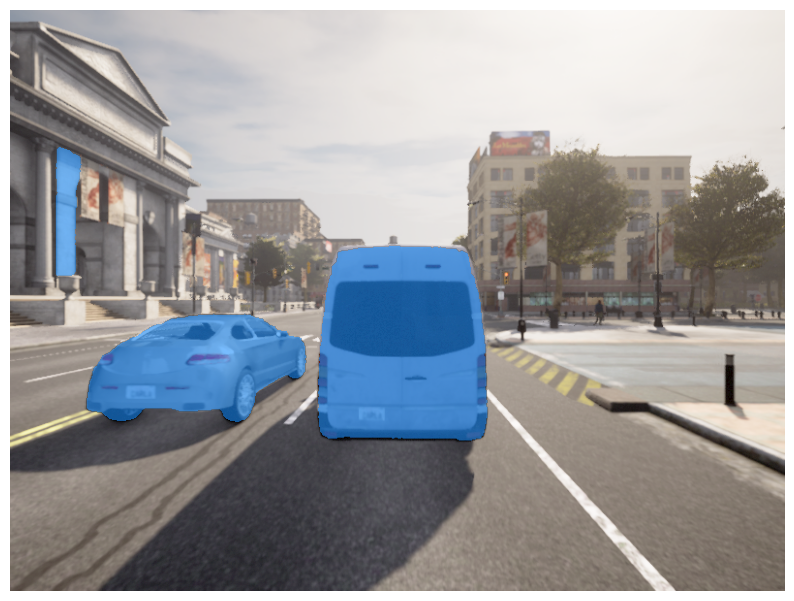

In [42]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_mask(masks2, plt.gca())
show_mask(masks3, plt.gca())
    # show_points(input_point, array, plt.gca())
    # plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
plt.axis('off')
plt.show()  

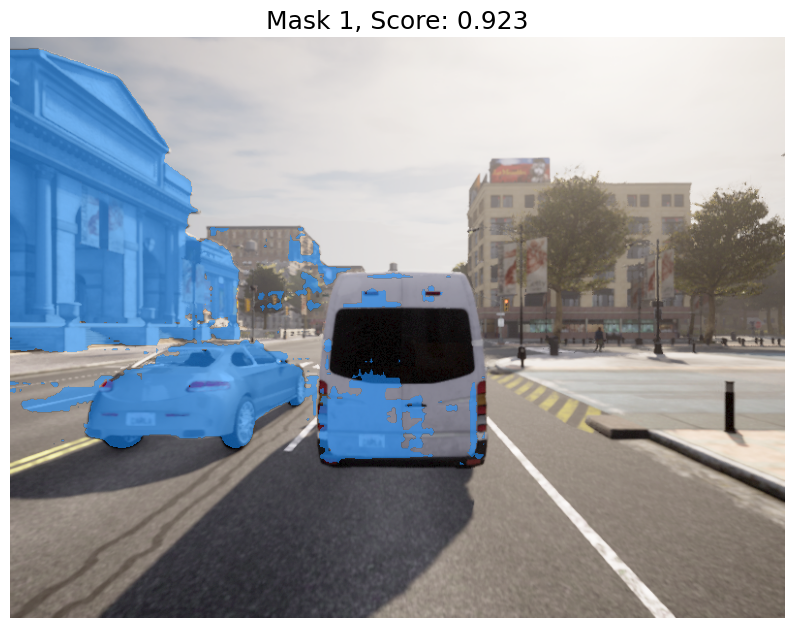

In [43]:
input_point=np.round(centroids).astype(int)
array=np.array([1,1,1])
# array=[1]
masks, scores, logits = predictor.predict(
    # point_coords=input_point,
    point_coords=input_point,
    point_labels=array,
    # mask_input=mask_input[None, :, :],
    multimask_output=False,
)
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    # show_points(input_point, array, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [44]:
image = cv2.imread('/home/irfan/research/HD_Map/HD_Map/rgb/00004663.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

[ WARN:0@751.065] global loadsave.cpp:241 findDecoder imread_('/home/irfan/research/HD_Map/HD_Map/rgb/00004663.png'): can't open/read file: check file path/integrity


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Load the .npy file
data = np.load('/home/irfan/research/HD_Map/HD_Map/dvs/00004663.npy', allow_pickle=True)

# Extract event data
timestamps = data.item()["t"]
x_coords = data.item()["x"]
y_coords = data.item()["y"]
polarities = data.item()["pol"]
print("polarities: ", polarities)
# Plot events
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, c=polarities, cmap='gray', marker='.', s=1)
plt.title('Event Camera Data')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.gca().invert_yaxis()  # Invert y-axis to match typical image coordinates
plt.colorbar(label='Polarity')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/irfan/research/HD_Map/HD_Map/dvs/00004663.npy'

In [ ]:
result = combine_arrays(x_coords, y_coords, polarities)
print(len(result))

In [ ]:
points=result

# Choose eps based on the k-distance graph (elbow method)
eps = 30 # Adjust this value based on the graph

# DBSCAN clustering
dbscan = DBSCAN(eps=eps, min_samples=500)
clusters = dbscan.fit_predict(points)

# Calculate centroids
unique_clusters = set(clusters)
centroids = []
for cluster in unique_clusters:
    if cluster != -1:  # Ignore noise points
        cluster_points = points[clusters == cluster]
        centroid = cluster_points.mean(axis=0)
        centroids.append(centroid)

centroids = np.array(centroids)

# Plotting the results
plt.scatter(points[:, 0], points[:, 1], c=clusters, cmap='plasma', label='Data Points')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', label='Centroids')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('DBSCAN Clustering with Centroids')
plt.legend()
plt.colorbar()
plt.show()

In [ ]:
input_point=centroids
array=np.ones(centroids.shape[0])
print(array)
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(centroids,array, plt.gca())
plt.axis('on')
plt.show()  

In [ ]:
predictor.set_image(image)

In [ ]:
input_point=np.round(centroids).astype(int)
array=np.ones(centroids.shape[0])

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=array,
    multimask_output=True,
)

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    # show_points(input_point, array, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# Load the .npy file
data = np.load('/home/irfan/research/HD_Map/HD_Map/dvs/00004899.npy', allow_pickle=True)

# Extract event data
timestamps = data.item()["t"]
x_coords = data.item()["x"]
y_coords = data.item()["y"]
polarities = data.item()["pol"]
print("polarities: ", polarities)
# Plot events
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, c=polarities, cmap='gray', marker='.', s=1)
plt.title('Event Camera Data')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.gca().invert_yaxis()  # Invert y-axis to match typical image coordinates
plt.colorbar(label='Polarity')
plt.show()

In [ ]:
import torch

# Load YOLOv5 model (you can also load custom trained models)
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5

In [ ]:
from deep_sort_realtime.deepsort_tracker import DeepSort

# Initialize DeepSORT
tracker = DeepSort(max_age=30, n_init=3, nms_max_overlap=1.0, max_iou_distance=0.7)


In [ ]:
import cv2
import numpy as np
 
#  detections = results.xyxy[0]  # Accessing first image in batch (if single image, just [0])
# detections: [x1, y1, x2, y2, confidence, class]

# Extract boxes (x1, y1, x2, y2), confidence scores, and class labels
# boxes = detections[:, :4]        # The first 4 columns are the bounding box coordinates
# scores = detections[:, 4]        # The 5th column is the confidence score
# labels = detections[:, 5]        # The 6th column is the class label
# Define a function to convert detections to SORT format.
def convert_detections(detections, threshold, classes):
    # Get the bounding boxes, labels and scores from the detections dictionary.
    boxes = detections[:, :4].cpu().numpy()
    labels = detections[:, 5] .cpu().numpy()
    scores = detections[:, 4].cpu().numpy()
    lbl_mask = np.isin(labels, classes)
    scores = scores[lbl_mask]
    # Filter out low confidence scores and non-person classes.
    mask = scores > threshold
    boxes = boxes[lbl_mask][mask]
    scores = scores[mask]
    labels = labels[lbl_mask][mask]
 
 
    # Convert boxes to [x1, y1, w, h, score] format.
    final_boxes = []
    for i, box in enumerate(boxes):
        # Append ([x, y, w, h], score, label_string).
        final_boxes.append(
            (
                [box[0], box[1], box[2] - box[0], box[3] - box[1]],
                scores[i],
                str(labels[i])
            )
        )
 
 
    return final_boxes

In [ ]:
results


In [ ]:
COCO_91_CLASSES = [
    '__background__',
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [ ]:
import cv2

frame_width = 800
frame_height = 600
fps = 30  # Frames per second
# video_length = 10  # Length of the video in seconds
output_file = 'output_video.avi'


# Open a video capture
cap = cv2.VideoCapture("/home/irfan/research/segment-anything/notebooks/output_video.mp4")
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Codec for .avi format
out = cv2.VideoWriter(output_file, fourcc, fps, (frame_width, frame_height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Object detection (YOLO)
    results = model(frame)
    dets=convert_detections(results.xyxy[0], 0.5, [0,1,2,3,4,5,6,7,8])    
    # print(dets)
    tracks = tracker.update_tracks(dets, frame=frame)
    # print(tracks)
    # Visualize results
    for track in tracks:
        if not track.is_confirmed():
            continue
        
        track_id = track.track_id
        ltrb = track.to_ltrb()  # Get bounding box in (left, top, right, bottom) format
        x1, y1, x2, y2 = map(int, ltrb)

        # Draw bounding box and label
        # print(x1, y1, x2, y2)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(frame, f'ID {track_id}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
    
    # Display the frame
    cv2.imwrite('frame.jpg', frame)
    out.write(frame)

out.release()
cap.release()



In [ ]:
detections=results.xyxy[0]
detections[:, 4]